In [17]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Traffic matrices and server popularity distributions

In [59]:
def generate_traffic_matrix(sending, receiving):
    # normalize vectors
    sending = sending / np.linalg.norm(sending)
    receiving = receiving / np.linalg.norm(receiving)

    # sending and receiving are vectors of length n, reshape them to be nx1 and 1xn
    sending = np.reshape(sending, (len(sending), 1))
    receiving = np.reshape(receiving, (1, len(receiving)))
    
    # multiply the two vectors to get an nxn matrix 
    matrix = sending @ receiving
    np.fill_diagonal(matrix, 0)
    
    return matrix / np.sum(matrix)

Different distributions for server popularity

In [22]:
def generate_unif(n):
    # generate a uniform vector of length n
    return np.ones(n) / n

In [23]:
def generate_random(n):
    # generate a random vector of length n
    popularities = np.random.rand(n)
    return popularities / np.linalg.norm(popularities)

In [24]:
def generate_gaussian(n, std=0.1):
    # generate a uniform vector of length n, with some Gaussian noise added. default std is 0.1
    popularities = np.random.rand(n) + np.random.normal(0, std, n)
    return popularities / np.linalg.norm(popularities)

In [25]:
# Generate popularities according to Pareto dist

def generate_zipf(n, repeat=1):
    """Returns nodes' popularities according to Zipf dist
    ARGS:
        n: number of nodes
        repeat: number of nodes with 1/i popularity
        
    OUTPUTS:
        popularities: list of popularity for each node, following an approximate Zipf distribution
    """
    
    popularities = np.array([1/np.ceil(i/repeat) for i in range(1,n+1)]) # repeated Zipf function
    return popularities / np.linalg.norm(popularities) # normalize


# Jellyfish

In [44]:
def create_jellyfish(num_switches, other_switches_per_switch, servers_per_switch):
    # indices 0 to num_switches - 1 are switches
    G = nx.random_regular_graph(d=other_switches_per_switch, n=num_switches)
    
    # indices num_switches to num_switches + num_switches * servers_per_switch - 1 are servers
    for i in range(num_switches):
        for j in range(servers_per_switch):
            server_index = num_switches + i * servers_per_switch + j 
            G.add_node(server_index)
            G.add_edge(i, server_index)
            # servers.append(server_index)
    
    # list of all servers
    servers = range(num_switches, num_switches + num_switches * servers_per_switch)
    
    return G, servers


In [79]:
G, servers = create_jellyfish(num_switches=50, other_switches_per_switch=4, servers_per_switch=4)
# G, servers = create_jellyfish(num_switches=10, other_switches_per_switch=3, servers_per_switch=2)
print(servers)
print(nx.shortest_path_length(G, source=30, target=55))
# pos = nx.shell_layout(G)
# nx.draw(G, pos)
# plt.show()

range(50, 250)
6


In [97]:
def switch_weight(source, target, edge_attr):
    if source in servers or target in servers:
        return 1
    else:
        return 0.144101239*len(servers) # https://ibmathsresources.com/2022/06/04/finding-the-average-distance-in-a-polygon/
    

def distance_weight(source, target, edge_attr):
    if source in servers or target in servers:
        return 1
    else:
        return np.abs(target-source)
    
nx.shortest_path_length(G, source=130, target=155, weight=distance_weight)


52

In [80]:
def calculate_weighted_path_length(G, servers, edge_weight=None):
    num_servers = len(servers)
    servers = np.random.permutation(servers) # randomly permute servers

    shortest_path_lengths = np.zeros((num_servers, num_servers))
    for i in range(num_servers):
        for j in range(num_servers):
            shortest_path_lengths[i, j] = nx.shortest_path_length(G, source=servers[i], target=servers[j], weight=edge_weight)

    unif_traffic_matrix = generate_traffic_matrix(generate_unif(num_servers), generate_unif(num_servers)) 
    print("Uniform traffic", np.sum(np.multiply(shortest_path_lengths, unif_traffic_matrix)))
    random_traffic_matrix = generate_traffic_matrix(generate_random(num_servers), generate_random(num_servers))
    print("Random traffic", np.sum(np.multiply(shortest_path_lengths, random_traffic_matrix)))
    gaussian_traffic_matrix = generate_traffic_matrix(generate_gaussian(num_servers, std=0.25), generate_gaussian(num_servers, std=0.25))
    print("Gaussian traffic", np.sum(np.multiply(shortest_path_lengths, gaussian_traffic_matrix)))
    zipf_traffic_matrix = generate_traffic_matrix(generate_zipf(num_servers, repeat=5), generate_zipf(num_servers, repeat=5))
    print("Zipf traffic", np.sum(np.multiply(shortest_path_lengths, zipf_traffic_matrix)))

    

In [98]:
calculate_weighted_path_length(G, servers, edge_weight=switch_weight)

Uniform traffic 85.88285188824122
Random traffic 85.80635924632631
Gaussian traffic 85.58397639749003
Zipf traffic 86.57830800751421


In [85]:
calculate_weighted_path_length(G, servers, edge_weight=distance_weight)

Uniform traffic 41.39939698492463
Random traffic 40.85267641215704
Gaussian traffic 41.12766662914396
Zipf traffic 42.55321063286481


# Fat-tree

In [92]:
def create_fattree(ports_per_switch):
    core_switches = ports_per_switch ** 2 // 2
    agg_switches = ports_per_switch ** 2 // 2
    edge_switches = ports_per_switch ** 2 // 2
    servers = ports_per_switch ** 3 // 4
    print("switches", core_switches + agg_switches + edge_switches, "servers", servers)

    G = nx.Graph()
    G.add_nodes_from(range(core_switches + agg_switches + edge_switches + servers))

    # connect core switches to agg switches
    for i in range(core_switches): # i is core switch index
        for j in range(agg_switches): # j is agg switch index
            if j%2 == 0 and i < ports_per_switch//2:
                G.add_edge(i, core_switches + j)
            elif j%2 == 1 and i >= ports_per_switch//2:
                G.add_edge(i, core_switches + j)
    
    # connect agg switches to edge switches
    for i in range(agg_switches): # i is agg switch index
        agg_pod = (i) // (ports_per_switch//2)
        for j in range(edge_switches): # j is edge switch index
            if (j) // (ports_per_switch//2) == agg_pod:
                G.add_edge(core_switches + i, core_switches + agg_switches + j)
    
    # connect edge switches to servers
    for i in range(edge_switches): # i is edge switch index
        for j in range(servers):
            if (j) // (ports_per_switch//2)**2 == i:
                G.add_edge(core_switches + agg_switches + i, core_switches + agg_switches + edge_switches + j)

    return G, range(core_switches + agg_switches + edge_switches, core_switches + agg_switches + edge_switches + servers)

    

switches 6 servers 2
switches 24 servers 16
switches 54 servers 54
switches 96 servers 128
range(96, 224)
1


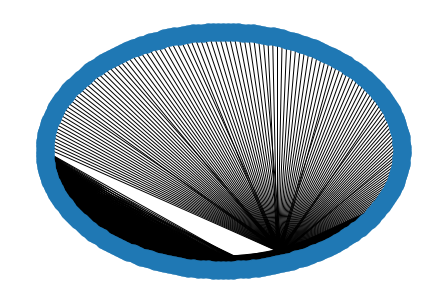

In [94]:
G2, servers2 = create_fattree(ports_per_switch=2)
G2, servers2 = create_fattree(ports_per_switch=4)
G2, servers2 = create_fattree(ports_per_switch=6)
G2, servers2 = create_fattree(ports_per_switch=8)
print(servers2)
print(nx.shortest_path_length(G2, source=20, target=35))
pos = nx.shell_layout(G2)
nx.draw(G2, pos)
plt.show()

In [96]:
calculate_weighted_path_length(G2, servers2, edge_weight=None)

Uniform traffic 4.771653543307087
Random traffic 4.756374500625565
Gaussian traffic 4.767482619297738
Zipf traffic 4.777215206554608


In [105]:
def core_weight(source, target, edge_attr):
    if source in core_switches or target in core_switches:
        return int(np.sqrt(2*core_switches)) + 1
    else:
        return 1

In [106]:
for k in [4, 6, 8]:
    G2, servers2 = create_fattree(ports_per_switch=k)
    core_switches = k ** 2 // 2
    calculate_weighted_path_length(G2, servers2, edge_weight=core_switches)
    print("\n")


switches 24 servers 16
Uniform traffic 4.666666666666666
Random traffic 4.685096771836234
Gaussian traffic 4.7530760776966465
Zipf traffic 4.691341256366723


switches 54 servers 54
Uniform traffic 4.716981132075473
Random traffic 4.719314950079628
Gaussian traffic 4.704575899400272
Zipf traffic 4.737058034809052


switches 96 servers 128
Uniform traffic 4.771653543307087
Random traffic 4.769679585543698
Gaussian traffic 4.773346390690353
Zipf traffic 4.803642735477002




In [103]:
for (num_switches, k) in [(24, 4), (54, 6), (96, 8)]:
    G, servers = create_jellyfish(num_switches=num_switches, other_switches_per_switch=k//2, servers_per_switch=k//2)
    calculate_weighted_path_length(G, servers, edge_weight=None)
    calculate_weighted_path_length(G, servers, edge_weight=switch_weight)
    print("\n")

Uniform traffic 8.127659574468087
Random traffic 8.162127377452023
Gaussian traffic 8.11842468602194
Zipf traffic 8.159641261121708
Uniform traffic 44.38416016885107
Random traffic 44.39768646446828
Gaussian traffic 44.553682303525754
Zipf traffic 44.83460598827362


Uniform traffic 5.913733609385783
Random traffic 5.906296334895365
Gaussian traffic 5.883501086862595
Zipf traffic 5.96375734405791
Uniform traffic 93.36376568100623
Random traffic 93.7008553523091
Gaussian traffic 93.50630261230252
Zipf traffic 92.9042175867366


Uniform traffic 5.499347258485638
Random traffic 5.4983056950476445
Gaussian traffic 5.49969572306783
Zipf traffic 5.500403152532458
Uniform traffic 195.63594584538896
Random traffic 195.30515707151235
Gaussian traffic 195.99550594946234
Zipf traffic 194.1587012826562




In [104]:
# more switch-switch connections
for (num_switches, k) in [(24, 4), (54, 6), (96, 8)]:
    G, servers = create_jellyfish(num_switches=num_switches, other_switches_per_switch=k-k//3, servers_per_switch=k//3)
    calculate_weighted_path_length(G, servers, edge_weight=None)
    calculate_weighted_path_length(G, servers, edge_weight=switch_weight)
    print("\n")

Uniform traffic 4.880434782608697
Random traffic 4.87917162262199
Gaussian traffic 4.895659771286769
Zipf traffic 4.932575317298139
Uniform traffic 11.961781304782612
Random traffic 11.952565471123688
Gaussian traffic 11.921881742636465
Zipf traffic 11.951503351680657


Uniform traffic 4.986500519210798
Random traffic 4.991478129882253
Gaussian traffic 4.990384132851211
Zipf traffic 4.956149567728914
Uniform traffic 48.47870990998129
Random traffic 48.63759434857512
Gaussian traffic 48.469810102855334
Zipf traffic 48.41720863241231


Uniform traffic 4.724694589877836
Random traffic 4.727370847333944
Gaussian traffic 4.7228877008647645
Zipf traffic 4.746274304185665
Uniform traffic 77.38531832921466
Random traffic 77.25182129733241
Gaussian traffic 77.43852324569785
Zipf traffic 77.48889999475622




In [107]:
# match number of servers
for (num_servers, k) in [(16, 4), (54, 6), (128, 8)]:
    num_switches = num_servers // (k // 3)
    G, servers = create_jellyfish(num_switches=num_switches, other_switches_per_switch=k-k//3, servers_per_switch=k//3)
    calculate_weighted_path_length(G, servers, edge_weight=None)
    calculate_weighted_path_length(G, servers, edge_weight=switch_weight)
    print("\n")

Uniform traffic 4.425000000000001
Random traffic 4.454875187860168
Gaussian traffic 4.515197792597837
Zipf traffic 4.413582342954159
Uniform traffic 7.5911280732
Random traffic 7.687827332666571
Gaussian traffic 7.398223018021491
Zipf traffic 7.684585922602375


Uniform traffic 4.2948986722571645
Random traffic 4.295233320540327
Gaussian traffic 4.284474303914378
Zipf traffic 4.274018110103846
Uniform traffic 19.857678070792453
Random traffic 19.92828916258481
Gaussian traffic 19.803017463708606
Zipf traffic 20.09371514982015


Uniform traffic 4.446850393700787
Random traffic 4.444738753337628
Gaussian traffic 4.453556405966055
Zipf traffic 4.464663684532844
Uniform traffic 47.13205419262992
Random traffic 47.212434849103516
Gaussian traffic 47.13013551535304
Zipf traffic 47.54101804726752


